In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd 
import wandb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rich.progress import track
from matplotlib.ticker import FormatStrFormatter

sns.set(context='paper', 
        style='ticks', 
        palette='deep', 
        font='Linux Libertine O', 
        font_scale=2.5, 
        rc={
            'mathtext.fontset': 'stix',
            'lines.linewidth' : 4,
            'lines.markersize' : 12,
        }
)
sns.despine()
os.makedirs('figs', exist_ok=True)

<Figure size 432x288 with 0 Axes>

In [3]:
wandb_user = 'sisaman'
wandb_project = 'GAP'

In [4]:
def get_dp_level(method: str):
    if method.endswith('-$\infty$'): return 'none'
    if method.endswith('-EDP'): return 'edge'
    if method.endswith('-NDP'): return 'node'
    if method == 'MLP': return 'edge'
    if method == 'MLP-DP': return 'node'

In [5]:
api = wandb.Api()
runs = api.runs(f"{wandb_user}/{wandb_project}", per_page=2000)

data_list = []
for run in track(runs): 
    data = {}
    data.update(run.summary._json_dict)
    data.update(run.config)
    data['id'] = run.name
    data['method'] = data['method'].upper().replace('INF', '$\infty$')    
    data_list.append(data)

# Trade-offs between Privacy and Accuracy

### Main results

In [66]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci']
methods = ['GAP-$\infty$', 'SAGE-$\infty$', 'GAP-EDP', 'SAGE-EDP', 'MLP', 'GAP-NDP', 'SAGE-NDP', 'MLP-DP']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df['dp_level'] = df['method'].apply(get_dp_level)
df.loc[df['method'] == 'MLP', 'epsilon'] = 0
df.loc[df['dp_level'] == 'none', 'epsilon'] = np.inf
df = df.loc[(df['dp_level'] != 'edge') | (df['epsilon'].isin([0,1]))]
df = df.loc[(df['dp_level'] != 'node') | (df['epsilon'] == 5)]

df.loc[df['method'] == 'SAGE-NDP', 'val/acc_mean'] = 0 # validation is disabled for SAGE-NDP
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['acc'] = df[['test/acc_mean', 'test/acc_ci']].apply(
    lambda row: '%.1f $\pm$ %.2f' % (row['test/acc_mean'], row['test/acc_ci']), axis=1
)
df = df.drop(columns=['id', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci'])

def sort_key(row):
    keys = {
        'facebook': 1, 'reddit': 2, 'amazon': 3,     # datasets
        'GAP-$\infty$': 1, 'SAGE-$\infty$': 2, 'GAP-EDP': 3, 'SAGE-EDP': 4, 'MLP': 5, 'GAP-NDP': 6, 'SAGE-NDP': 7, 'MLP-DP': 8,  # methods
        'none': 1, 'edge': 2, 'node': 3,  # levels
    }
    if isinstance(row, pd.Index):
        s = row.to_series()
        s = s.replace(keys)
        return pd.Index(s)
    else:
        return row.replace(keys)

df = df.sort_values(by=['dataset', 'dp_level', 'method'], key=sort_key)
df = df.pivot(columns='dataset', index=['dp_level', 'method', 'epsilon'], values='acc')
df = df.reset_index().sort_values(
    by=['dp_level', 'method'],
    key=sort_key
).set_index(['dp_level', 'method', 'epsilon'])
df = df.sort_index(axis=1, key=sort_key)
df = df.rename(str.title, axis=1)
df = df.rename(str.title, axis=0, level=0)
df = df.rename_axis(index={'dp_level': 'Privacy Level', 'epsilon': 'privacy cost'})
df = df.rename_axis(index=str.title)
df = df.rename_axis(columns=str.title)
df = df.rename({np.inf: '$\infty$'}, axis=0, level=2)
# print(df.to_latex(escape=False))
df

Dataset                                          Facebook           Reddit  \
Privacy Level Method        Privacy Cost                                     
None          GAP-$\infty$  $\infty$      80.0 $\pm$ 0.48  99.4 $\pm$ 0.02   
              SAGE-$\infty$ $\infty$      83.2 $\pm$ 0.68  99.1 $\pm$ 0.01   
Edge          GAP-EDP       1.0           69.2 $\pm$ 0.46  97.5 $\pm$ 0.06   
              SAGE-EDP      1.0           48.3 $\pm$ 0.69  71.0 $\pm$ 2.72   
              MLP           0.0           50.8 $\pm$ 0.17  82.4 $\pm$ 0.10   
Node          GAP-NDP       5.0           58.5 $\pm$ 0.25  92.1 $\pm$ 0.15   
              SAGE-NDP      5.0           21.9 $\pm$ 1.32  45.3 $\pm$ 1.92   
              MLP-DP        5.0           50.2 $\pm$ 0.24  81.3 $\pm$ 0.16   

Dataset                                            Amazon  
Privacy Level Method        Privacy Cost                   
None          GAP-$\infty$  $\infty$      91.2 $\pm$ 0.07  
              SAGE-$\infty$ $\infty$      92.7 $\pm$ 0.09  
Edge          GAP-EDP       1.0           77.5 $\pm$ 0.18  
              SAGE-EDP      1.0           68.3 $\pm$ 0.89  
              MLP           0.0           71.1 $\pm$ 0.18  
Node          GAP-NDP       5.0           75.9 $\pm$ 0.06  
              SAGE-NDP      5.0           27.2 $\pm$ 1.27  
              MLP-DP        5.0           73.5 $\pm$ 0.05

## Edge-level DP

### Low to moderate privacy budgets

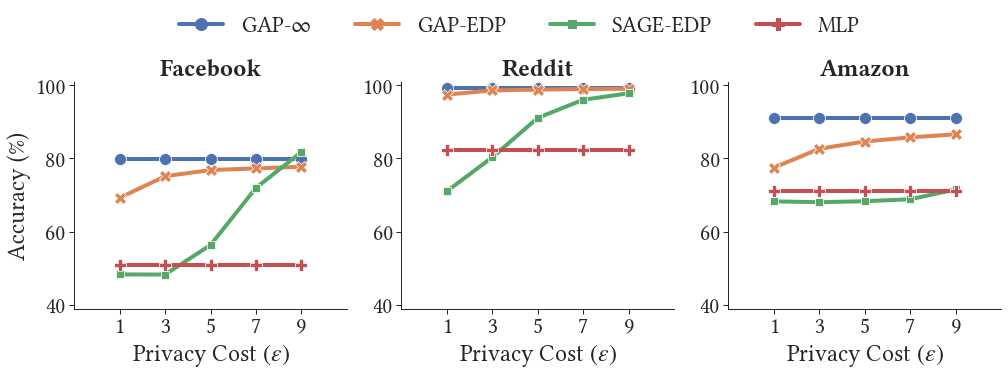

In [26]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-$\infty$', 'GAP-EDP', 'SAGE-EDP', 'MLP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [1,3,5,7,9]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'MLP', 'epsilon'] = 0
df.loc[df['method'] == 'GAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[0,np.inf])]

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
df = df.explode(column='epsilon')
df = df.reset_index(drop=True)

# plot
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                markers=True, dashes=False, style='method',
                hue_order=methods, col_order=datasets, style_order=methods,
                facet_kws={'sharey': False, 'sharex': False})

sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))
g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xlim=(-1,11), xticks=epsilons)

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )

g.axes[0][0].set(ylim=(39,101),ylabel='Accuracy (%)')
g.axes[0][1].set(ylim=(39,101))
g.axes[0][2].set_ylim(39,101)
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/edge-medium.pdf')

### Very low privacy budgets

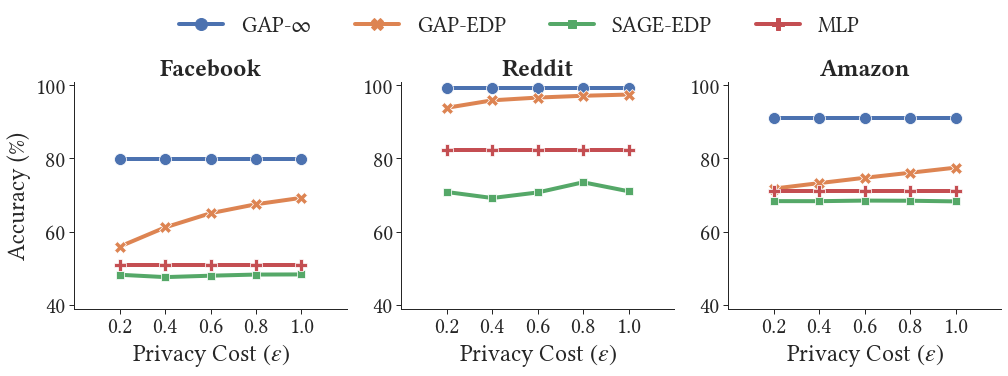

In [28]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-$\infty$', 'GAP-EDP', 'SAGE-EDP', 'MLP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [0.2, 0.4, 0.6, 0.8, 1]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'MLP', 'epsilon'] = 0
df.loc[df['method'] == 'GAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[0,np.inf])]

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
df = df.explode(column='epsilon')
df = df.reset_index(drop=True)

# plot
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                markers=True, dashes=False, style='method',
                hue_order=methods, col_order=datasets, style_order=methods,
                facet_kws={'sharey': False, 'sharex': False})

sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))
g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xlim=(0,1.2), xticks=epsilons)

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )

g.axes[0][0].set(ylim=(39,101),ylabel='Accuracy (%)')
g.axes[0][1].set(ylim=(39,101))
g.axes[0][2].set_ylim(39,101)
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/edge-low.pdf')

## Node-level DP

### Moderate privacy budgets

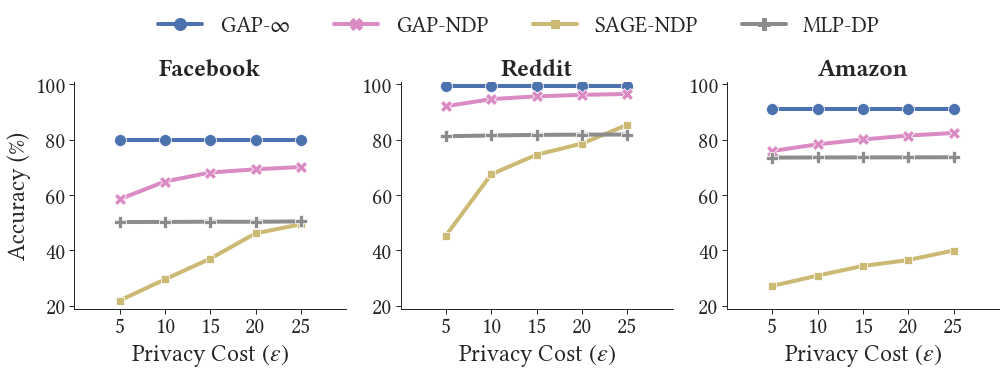

In [27]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-$\infty$', 'GAP-NDP', 'SAGE-NDP', 'MLP-DP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [5,10,15,20,25]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'GAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[np.inf])]

# select best models based on valication accuracy
df.loc[df['method'] == 'SAGE-NDP', 'val/acc_mean'] = 0 # validation is disabled for SAGE-NDP
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
df = df.explode(column='epsilon')
df = df.reset_index(drop=True)

# plot
palette = sns.color_palette()
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                markers=True, dashes=False, style='method',
                hue_order=methods, col_order=datasets, style_order=methods, 
                palette=[palette[0], palette[-4], palette[-2], palette[-3]],
                facet_kws={'sharey': False, 'sharex': False})

sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))
g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xlim=(0,30), xticks=epsilons)

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )

g.axes[0][0].set(ylim=(19,101),ylabel='Accuracy (%)')
g.axes[0][1].set(ylim=(19,101),)
g.axes[0][2].set_ylim(19,101)

g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/node-medium.pdf')

### Low privacy budgets

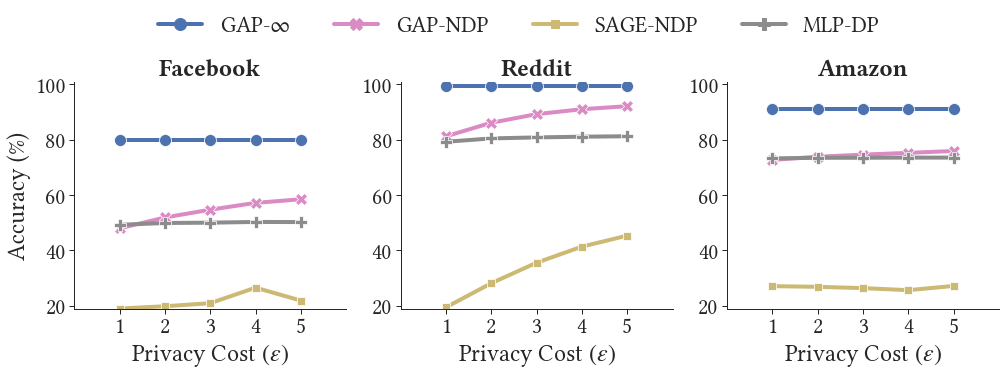

In [29]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-$\infty$', 'GAP-NDP', 'SAGE-NDP', 'MLP-DP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [1,2,3,4,5]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'GAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[np.inf])]

# select best models based on valication accuracy
df.loc[df['method'] == 'SAGE-NDP', 'val/acc_mean'] = 0 # validation is disabled for SAGE-NDP
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
df = df.explode(column='epsilon')
df = df.reset_index(drop=True)

# plot
palette = sns.color_palette()
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                markers=True, dashes=False, style='method',
                hue_order=methods, col_order=datasets, style_order=methods, 
                palette=[palette[0], palette[-4], palette[-2], palette[-3]],
                facet_kws={'sharey': False, 'sharex': False})

sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))
g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xlim=(0,6), xticks=epsilons)

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )

g.axes[0][0].set(ylim=(19,101),ylabel='Accuracy (%)')
g.axes[0][1].set(ylim=(19,101),)
g.axes[0][2].set_ylim(19,101)

g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/node-low.pdf')

# Effectiveness of the encoder module

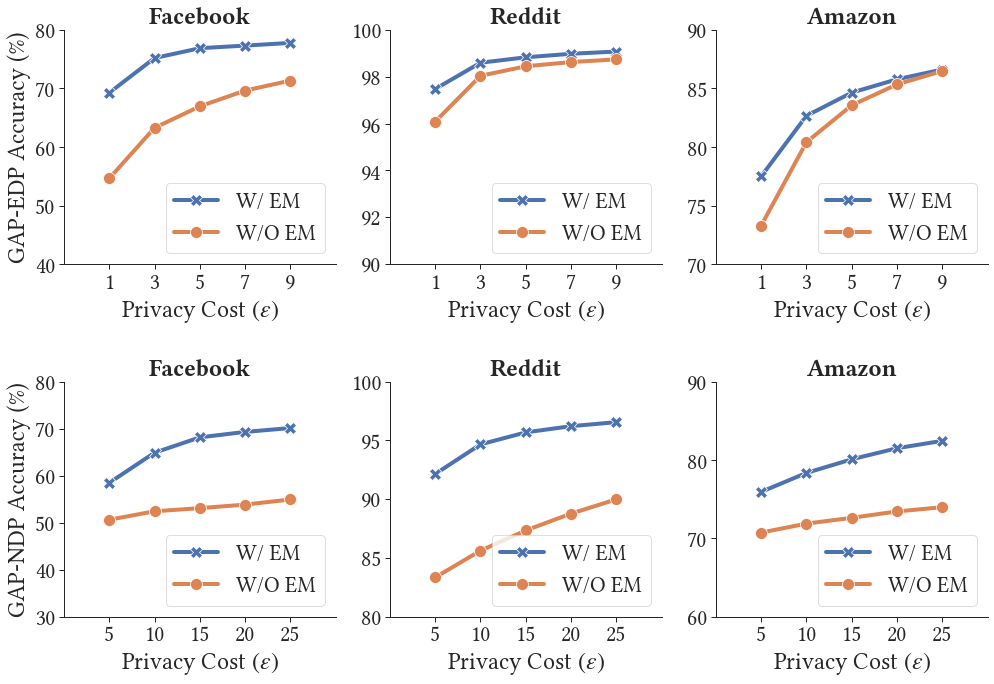

In [36]:
cols = ['id', 'method', 'hops', 'dataset', 'encoder_layers', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-EDP', 'GAP-NDP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons_edp = [1,3,5,7,9]
epsilons_ndp = [5,10,15,20,25]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]

mask_edp = (df['method'] == 'GAP-EDP') & df['epsilon'].isin(epsilons_edp)
mask_ndp = (df['method'] == 'GAP-NDP') & df['epsilon'].isin(epsilons_ndp)
df = df.loc[mask_edp | mask_ndp]


# select best models based on valication accuracy
idx = df.groupby(['dataset', 'method', 'epsilon', 'encoder_layers'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['encoder_layers'] = df['encoder_layers'].astype(int).astype(str)
df = df.reset_index(drop=True)

g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='encoder_layers', col='dataset', row='method', aspect=1.2,
                col_order=datasets, row_order=methods, hue_order=['2', '0'], markers=True, dashes=False, style='encoder_layers', legend=False,
                facet_kws={'sharey': False, 'sharex': False})

g.set(xlabel='Privacy Cost $(\epsilon)$')
for method, axes in zip(methods, g.axes):
    for dataset, ax in zip(datasets, axes):
        ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
        ax.set_xlim((-1,11) if method=='GAP-EDP' else (0,30))
        ax.set_xticks(epsilons_edp if method=='GAP-EDP' else epsilons_ndp)
        # ax.set_yticks(range(60,95,5) if dataset == 'amazon' else range(30,85,10))
        ax.legend(labels=['W/ EM', 'W/O EM'], loc='lower right')
        ax.set_ylabel(f'{method} Accuracy (%)' if dataset == datasets[0] else None)
g.fig.subplots_adjust(hspace=0.5, wspace=0.4)
g.axes[0][0].set_ylim(40,80)
g.axes[0][1].set_ylim(90,100)
g.axes[0][2].set_ylim(70,90)
g.axes[1][0].set_ylim(30,80)
g.axes[1][1].set_ylim(80,100)
g.axes[1][2].set_ylim(60,90)

g.fig.subplots_adjust(hspace=0.5, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/encoder.pdf')

# Effect of the number of hops

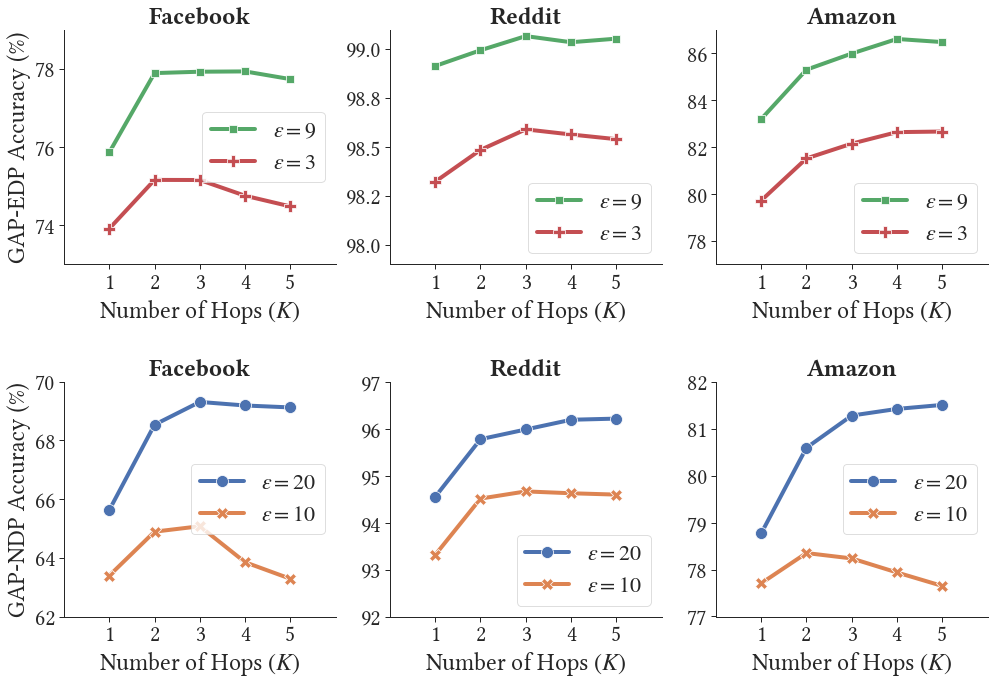

In [57]:
cols = ['method', 'dataset', 'epsilon', 'hops', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-EDP', 'GAP-NDP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons_edp = [3,9]
epsilons_ndp = [10,20]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]

mask_edp = (df['method'] == 'GAP-EDP') & df['epsilon'].isin(epsilons_edp)
mask_ndp = (df['method'] == 'GAP-NDP') & df['epsilon'].isin(epsilons_ndp)
df = df.loc[mask_edp | mask_ndp]

# select best models based on valication accuracy
idx = df.groupby(['method', 'dataset', 'epsilon', 'hops'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
epsilons = list(map(str, epsilons))
df['epsilon'] = df['epsilon'].astype(int).astype(str)

g = sns.relplot(kind='line', data=df, hue='epsilon', y='test/acc_mean', x='hops', col='dataset', row='method', aspect=1.2,
                col_order=datasets, row_order=methods, markers=True, dashes=False, style='epsilon', legend=False,
                facet_kws={'sharey': False, 'sharex': False})

legend_loc = {
    ('GAP-EDP', 'reddit'): 'lower right',
    ('GAP-NDP', 'facebook'): 'right',
}

g.set(xlabel='Number of Hops $(K)$', xlim=(0,6), xticks=range(1,6))
for method, axes in zip(methods, g.axes):
    for dataset, ax in zip(datasets, axes):
        ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
        ax.legend(
            labels=[f'$\epsilon={eps}$' for eps in df.loc[(df['method'] == method) & (df['dataset'] == dataset), 'epsilon'].unique()],
            loc=legend_loc.get((method, dataset), None),
        )
        ax.set_ylabel(f'{method} Accuracy (%)' if dataset == datasets[0] else None)
        
g.axes[0][0].set(ylim=(73,79))
g.axes[0][1].set(ylim=(97.9,99.1)); g.axes[0][1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
g.axes[0][2].set_ylim(77,87)
g.axes[1][0].set_ylim(62,70)
g.axes[1][1].set(ylim=(92,97))
g.axes[1][2].set_ylim(77,82)


g.fig.subplots_adjust(hspace=0.5, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/hops.pdf')
# df

# Effect of the maximum degree

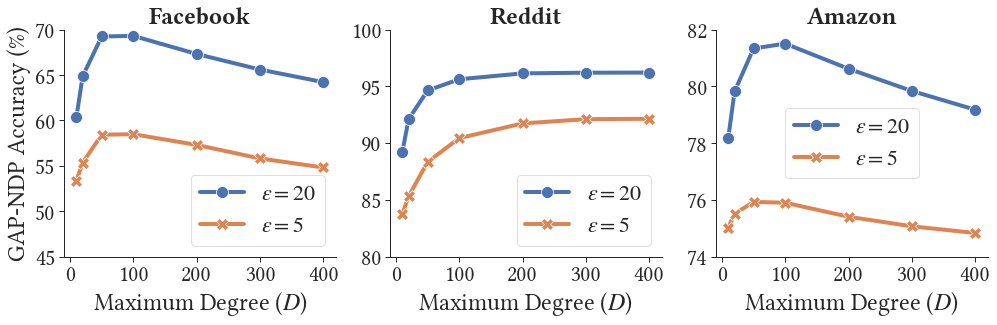

In [62]:
cols = ['method', 'dataset', 'epsilon', 'max_degree', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-NDP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [20,5]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons)]

# select best models based on valication accuracy
idx = df.groupby(['method', 'dataset', 'epsilon', 'max_degree'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
epsilons = list(map(str, epsilons))
df['epsilon'] = df['epsilon'].astype(int).astype(str)

g = sns.relplot(kind='line', data=df, x='max_degree', y='test/acc_mean', hue='epsilon',
                col='dataset', aspect=1.2,
                col_order=datasets, 
                hue_order=epsilons, 
                markers=True, dashes=False, style='epsilon', legend=False,
                facet_kws={'sharey': False, 'sharex': False})

g.set(xlabel='Maximum Degree ($D$)', ylabel=None)
for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.set_xticks(range(0,450,100))
    ax.legend(labels=[f"$\epsilon={eps}$" for eps in epsilons], ncol=1,)
        
g.axes[0][0].set(ylim=(45,70), ylabel='GAP-NDP Accuracy (%)')
g.axes[0][1].set_ylim(80,100)
g.axes[0][2].set_ylim(74,82)

g.fig.subplots_adjust(hspace=0.5, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/degree.pdf')

# Computational Cost

In [63]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'fit_time_mean', 'fit_time_ci']
methods = ['GAP-$\infty$', 'SAGE-$\infty$', 'GAP-EDP', 'SAGE-EDP', 'MLP', 'GAP-NDP', 'SAGE-NDP', 'MLP-DP']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df['dp_level'] = df['method'].apply(get_dp_level)
df.loc[df['method'] == 'MLP', 'epsilon'] = 0
df.loc[df['dp_level'] == 'none', 'epsilon'] = np.inf
df = df.loc[(df['dp_level'] != 'edge') | (df['epsilon'].isin([0,5]))]
df = df.loc[(df['dp_level'] != 'node') | (df['epsilon'] == 15)]

df.loc[df['method'] == 'SAGE-NDP', 'val/acc_mean'] = 0 # validation is disabled for SAGE-NDP
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['time'] = df[['fit_time_mean', 'fit_time_ci']].apply(
    lambda row: '%.1f $\pm$ %.2f' % (row['fit_time_mean'], row['fit_time_ci']), axis=1
)
df = df.drop(columns=['id', 'val/acc_mean', 'fit_time_mean', 'fit_time_ci'])

def sort_key(row):
    keys = {
        'facebook': 1, 'reddit': 2, 'amazon': 3,     # datasets
        'GAP-$\infty$': 1, 'SAGE-$\infty$': 2, 'GAP-EDP': 3, 'SAGE-EDP': 4, 'MLP': 5, 'GAP-NDP': 6, 'SAGE-NDP': 7, 'MLP-DP': 8,  # methods
        'none': 1, 'edge': 2, 'node': 3,  # levels
    }
    if isinstance(row, pd.Index):
        s = row.to_series()
        s = s.replace(keys)
        return pd.Index(s)
    else:
        return row.replace(keys)

df = df.sort_values(by=['dataset', 'dp_level', 'method'], key=sort_key)
df = df.pivot(columns='dataset', index=['dp_level', 'method', 'epsilon'], values='time')
df = df.reset_index().sort_values(
    by=['dp_level', 'method'],
    key=sort_key
).set_index(['dp_level', 'method', 'epsilon'])
df = df.sort_index(axis=1, key=sort_key)
df = df.rename(str.title, axis=1)
df = df.rename(str.title, axis=0, level=0)
df = df.rename_axis(index={'dp_level': 'Privacy Level', 'epsilon': 'privacy cost'})
df = df.rename_axis(index=str.title)
df = df.rename_axis(columns=str.title)
df = df.rename({np.inf: '$\infty$'}, axis=0, level=2)
# print(df.to_latex(escape=False))
df

Dataset                                          Facebook            Reddit  \
Privacy Level Method        Privacy Cost                                      
None          GAP-$\infty$  $\infty$       1.8 $\pm$ 0.57    2.0 $\pm$ 0.56   
              SAGE-$\infty$ $\infty$       2.8 $\pm$ 0.92   74.0 $\pm$ 0.48   
Edge          GAP-EDP       5.0            2.5 $\pm$ 1.06    3.6 $\pm$ 0.39   
              SAGE-EDP      5.0            2.2 $\pm$ 1.40    8.3 $\pm$ 0.28   
              MLP           0.0            1.6 $\pm$ 1.50    0.9 $\pm$ 0.24   
Node          GAP-NDP       15.0           8.7 $\pm$ 1.13   15.4 $\pm$ 1.04   
              SAGE-NDP      15.0          16.9 $\pm$ 6.40  50.6 $\pm$ 21.18   
              MLP-DP        15.0           4.6 $\pm$ 2.18    1.7 $\pm$ 0.47   

Dataset                                             Amazon  
Privacy Level Method        Privacy Cost                    
None          GAP-$\infty$  $\infty$       15.3 $\pm$ 0.25  
              SAGE-$\infty$ $\infty$       67.5 $\pm$ 1.10  
Edge          GAP-EDP       5.0            15.4 $\pm$ 0.36  
              SAGE-EDP      5.0           196.3 $\pm$ 0.22  
              MLP           0.0             6.4 $\pm$ 0.86  
Node          GAP-NDP       15.0           40.1 $\pm$ 2.96  
              SAGE-NDP      15.0          168.6 $\pm$ 2.15  
              MLP-DP        15.0           10.9 $\pm$ 0.76

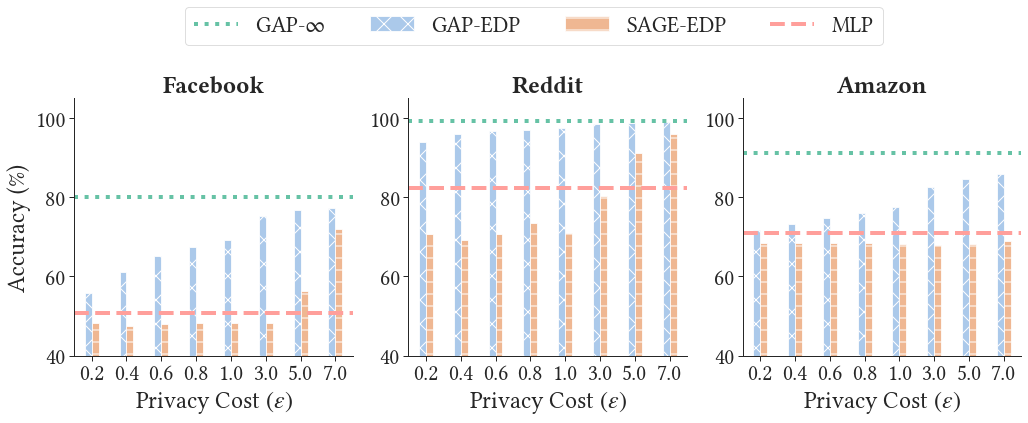

In [47]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-$\infty$', 'GAP-EDP', 'SAGE-EDP', 'MLP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [0.2, 0.4, 0.6, 0.8, 1,3,5,7]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'MLP', 'epsilon'] = 0
df.loc[df['method'] == 'GAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[0,np.inf])]

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
# df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
# df = df.explode(column='epsilon')
# df = df.reset_index(drop=True)

inf_acc = df.loc[df['method'] == 'GAP-$\infty$', ['dataset', 'test/acc_mean']].set_index('dataset')
mlp_acc = df.loc[df['method'] == 'MLP', ['dataset', 'test/acc_mean']].set_index('dataset')
edp_methods = ['GAP-EDP', 'SAGE-EDP']
df = df.loc[df['method'].isin(edp_methods)]
# df[df['method'].isin(['GAP-$\infty$', 'MLP'])] = None

# plot
g = sns.catplot(kind='bar', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                # markers=True, dashes=False, style='method',
                hue_order=edp_methods, col_order=datasets, #style_order=methods,
                **{'sharey': False, 'sharex': False}, legend=False, palette='pastel')

g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', ylim=(40,105))

def change_width(ax, new_value) :
    hatches = ['x', '-', 'o']
    for i, patch in enumerate(ax.patches) :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)
        patch.set_hatch(hatches[i // len(epsilons)])

        # we recenter the bar
        if i < len(ax.patches) / 2 :
            patch.set_x(patch.get_x() + diff * 1)

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_acc.loc[dataset].item(), linestyle='dotted', label='GAP-$\infty$', color=sns.color_palette('Set2')[0])
    ax.axhline(mlp_acc.loc[dataset].item(), linestyle='dashed', label='MLP', color=sns.color_palette('pastel')[3])
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'})
    change_width(ax, 0.2)

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.axes[0][1].legend(loc='upper center', ncol=4, bbox_to_anchor=(.45, 1.4), handles=[legend_data[method] for method in methods], labels=methods)
# g.add_legend(legend_data=legend_data, title=None, loc='upper center', bbox_to_anchor=(.45, 1.1), label_order=methods)
# sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))

g.axes[0][0].set(ylabel='Accuracy (%)')
# g.axes[0][1].set(ylim=(39,101))
# g.axes[0][2].set_ylim(39,101)
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/edge-medium.pdf')

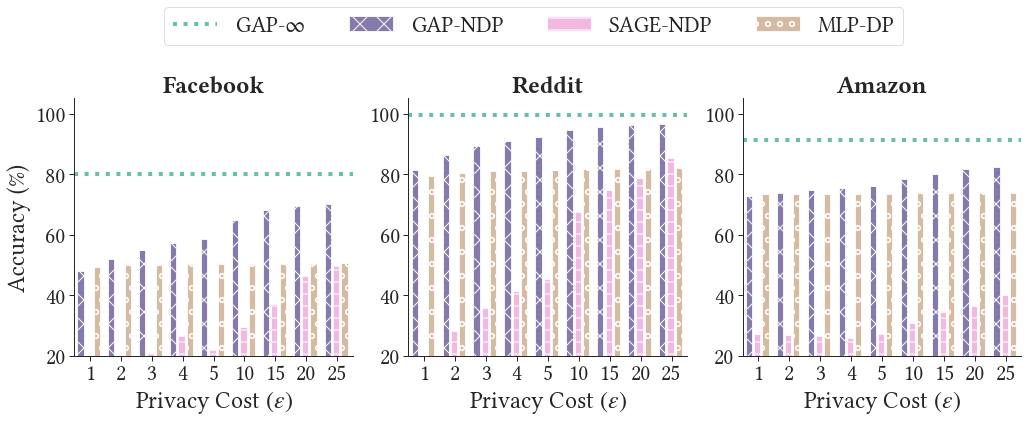

In [48]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-$\infty$', 'GAP-NDP', 'SAGE-NDP', 'MLP-DP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [1,2,3,4,5,10,15,20,25,]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'GAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[np.inf])]

# select best models based on valication accuracy
df.loc[df['method'] == 'SAGE-NDP', 'val/acc_mean'] = 0 # validation is disabled for SAGE-NDP
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
# df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
# df = df.explode(column='epsilon')
# df = df.reset_index(drop=True)

inf_acc = df.loc[df['method'] == 'GAP-$\infty$', ['dataset', 'test/acc_mean']].set_index('dataset')
ndp_methods = ['GAP-NDP', 'SAGE-NDP', 'MLP-DP']
df = df.loc[df['method'].isin(ndp_methods)]
df['epsilon'] = df['epsilon'].astype(int)
# df[df['method'].isin(['GAP-$\infty$', 'MLP'])] = None

# plot
g = sns.catplot(kind='bar', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                # markers=True, dashes=False, style='method',
                hue_order=ndp_methods, col_order=datasets, #style_order=methods,
                **{'sharey': False, 'sharex': False}, legend=False, palette=[
                    sns.color_palette('deep')[4],
                    sns.color_palette('pastel')[6],
                    sns.color_palette('pastel')[5],
                ])

g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', ylim=(20,105))

def change_width(ax, new_value) :
    hatches = ['x', '-', 'o']
    for i, patch in enumerate(ax.patches) :
        current_width = patch.get_width()
        # diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)
        patch.set_hatch(hatches[i // len(epsilons)])
        # we recenter the bar
        # if i < len(ax.patches) / 2 :
        #     patch.set_x(patch.get_x() + diff * 1)

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_acc.loc[dataset].item(), linestyle='dotted', label='GAP-$\infty$', color=sns.color_palette('Set2')[0])
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'})
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    change_width(ax, 0.2)

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.axes[0][1].legend(loc='upper center', ncol=4, bbox_to_anchor=(.45, 1.4), handles=[legend_data[method] for method in methods], labels=methods)
# g.add_legend(legend_data=legend_data, title=None, loc='upper center', bbox_to_anchor=(.45, 1.1), label_order=methods)
# sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))

g.axes[0][0].set(ylabel='Accuracy (%)')
# g.axes[0][1].set(ylim=(39,101))
# g.axes[0][2].set_ylim(39,101)
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/node-medium.pdf')

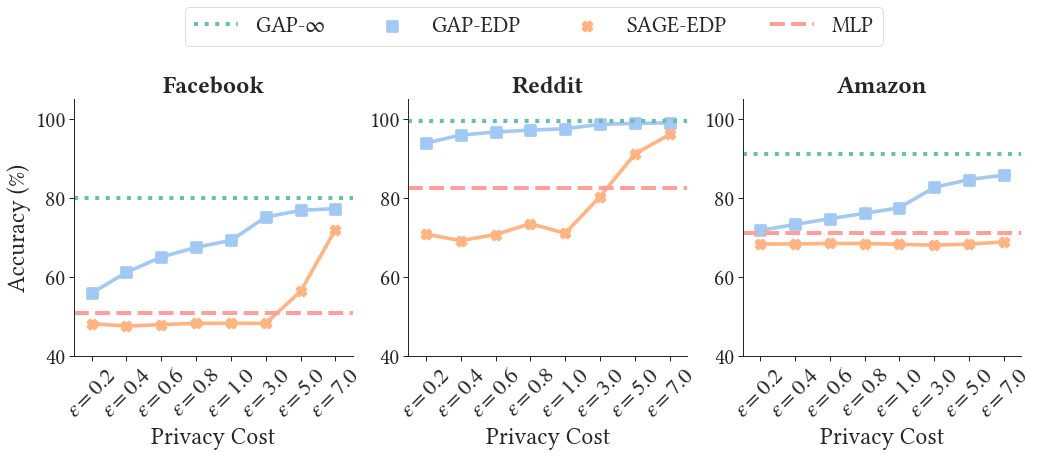

In [86]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-$\infty$', 'GAP-EDP', 'SAGE-EDP', 'MLP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [0.2, 0.4, 0.6, 0.8, 1,3,5,7]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'MLP', 'epsilon'] = 0
df.loc[df['method'] == 'GAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[0,np.inf])]

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
# df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
# df = df.explode(column='epsilon')
# df = df.reset_index(drop=True)

inf_acc = df.loc[df['method'] == 'GAP-$\infty$', ['dataset', 'test/acc_mean']].set_index('dataset')
mlp_acc = df.loc[df['method'] == 'MLP', ['dataset', 'test/acc_mean']].set_index('dataset')
edp_methods = ['GAP-EDP', 'SAGE-EDP']
df = df.loc[df['method'].isin(edp_methods)]
# df[df['method'].isin(['GAP-$\infty$', 'MLP'])] = None

# plot
g = sns.catplot(kind='point', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                # markers=True, dashes=False, style='method',
                hue_order=edp_methods, col_order=datasets, #style_order=methods,
                **{'sharey': False, 'sharex': False}, legend=False, palette='pastel',
                scale=0.5, markers=['s', 'X'])

g.set(ylabel=None, xlabel='Privacy Cost', ylim=(40,105), xticklabels=[f'$\epsilon={e:.1f}$' for e in epsilons])

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_acc.loc[dataset].item(), linestyle='dotted', label='GAP-$\infty$', color=sns.color_palette('Set2')[0])
    ax.axhline(mlp_acc.loc[dataset].item(), linestyle='dashed', label='MLP', color=sns.color_palette('pastel')[3])
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'})
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.axes[0][1].legend(loc='upper center', ncol=4, bbox_to_anchor=(.45, 1.4), handles=[legend_data[method] for method in methods], labels=methods)
# g.add_legend(legend_data=legend_data, title=None, loc='upper center', bbox_to_anchor=(.45, 1.1), label_order=methods)
# sns.move_legend(g, loc='upper center', title=None, ncol=6, bbox_to_anchor=(.45, 1.1))

g.axes[0][0].set(ylabel='Accuracy (%)')
# g.axes[0][1].set(ylim=(39,101))
# g.axes[0][2].set_ylim(39,101)
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/edge-medium.pdf')

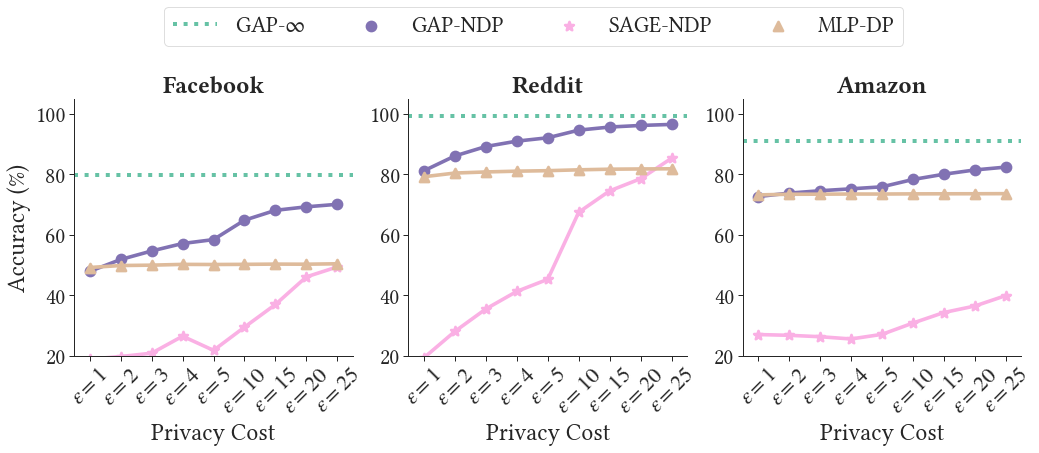

In [87]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['GAP-$\infty$', 'GAP-NDP', 'SAGE-NDP', 'MLP-DP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [1,2,3,4,5,10,15,20,25,]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'GAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[np.inf])]

# select best models based on valication accuracy
df.loc[df['method'] == 'SAGE-NDP', 'val/acc_mean'] = 0 # validation is disabled for SAGE-NDP
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# expand epsilon for methods with eps=0 or eps=inf
# df['epsilon'] = df['epsilon'].apply(lambda eps: epsilons if eps in (np.inf, 0) else eps)
# df = df.explode(column='epsilon')
# df = df.reset_index(drop=True)

inf_acc = df.loc[df['method'] == 'GAP-$\infty$', ['dataset', 'test/acc_mean']].set_index('dataset')
ndp_methods = ['GAP-NDP', 'SAGE-NDP', 'MLP-DP']
df = df.loc[df['method'].isin(ndp_methods)]
df['epsilon'] = df['epsilon'].astype(int)
# df[df['method'].isin(['GAP-$\infty$', 'MLP'])] = None

# plot
g = sns.catplot(kind='point', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                # markers=True, dashes=False, style='method',
                hue_order=ndp_methods, col_order=datasets, #style_order=methods,
                **{'sharey': False, 'sharex': False}, legend=False, scale=0.5, markers=['o', '*', '^'], palette=[
                    sns.color_palette('deep')[4],
                    sns.color_palette('pastel')[6],
                    sns.color_palette('pastel')[5],
                ])

g.set(ylabel=None, xlabel='Privacy Cost', ylim=(20,105), xticklabels=[f'$\epsilon={e:5d}$' for e in epsilons])

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_acc.loc[dataset].item(), linestyle='dotted', label='GAP-$\infty$', color=sns.color_palette('Set2')[0])
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'})
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.axes[0][1].legend(loc='upper center', ncol=4, bbox_to_anchor=(.45, 1.4), 
    handles=[legend_data[method] for method in methods], labels=methods)

g.axes[0][0].set(ylabel='Accuracy (%)')
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/node-medium.pdf')